# E-Commerce Customers Churn Prediction and Customer Segmentation

## The Likelihood Customer Who Got Cashback Churning

In [1]:
# Basic Operations
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.feature_selection import SelectPercentile, RFE
from imblearn.pipeline import Pipeline

# Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, plot_roc_curve, plot_precision_recall_curve, confusion_matrix
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

# Saving Model
import pickle

# Warnings
import warnings 
warnings.filterwarnings('ignore')

In [36]:
# Load the data
df=pd.read_csv('E Commerce Dataset.csv')

In [37]:
# See overview of the data
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


## Understanding the Data

### Dataset Information
The e-commerce dataset contains data about,    
CustomerID : Unique customer ID  
Churn : Churn Flag    
Tenure : Tenure of customer in organization    
PreferredLoginDevice : Preferred login device of customer   
CityTier : City tier  
WarehouseToHome : Distance in between warehouse to home of customer  
PreferredPaymentMode : Preferred payment method of customer  
Gender : Gender of customer  
HourSpendOnApp : Number of hours spend on mobile application or website  
NumberOfDeviceRegistered : Total number of deceives is registered on particular customer  
PreferedOrderCat : Preferred order category of customer in last month    
SatisfactionScore : Satisfactory score of customer on service    
MaritalStatus : Marital status of customer    
NumberOfAddress : Total number of added added on particular customer  
Complain : Any complaint has been raised in last month    
OrderAmountHikeFromlastYear : Percentage increases in order from last year  
CouponUsed : Total number of coupon has been used in last month  
OrderCount : Total number of orders has been places in last month  
DaySinceLastOrder : Day Since last order by customer    
CashbackAmount : Average cashback in last month  

In [38]:
 # See how many columns and rows are available for this dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [39]:
# Because the values are unique for each row as identifier, column Customer ID is deleted
df=df.drop('CustomerID', axis=1)

In [40]:
# Find Q1, Q3, and, IQR for detecting outlier
Q1=df.describe().loc['25%']
Q3=df.describe().loc['75%']
IQR=Q3-Q1
IQR

Churn                           0.0
Tenure                         14.0
CityTier                        2.0
WarehouseToHome                11.0
HourSpendOnApp                  1.0
NumberOfDeviceRegistered        1.0
SatisfactionScore               2.0
NumberOfAddress                 4.0
Complain                        1.0
OrderAmountHikeFromlastYear     5.0
CouponUsed                      1.0
OrderCount                      2.0
DaySinceLastOrder               5.0
CashbackAmount                 50.0
dtype: float64

In [41]:
# Check missing value, duplicate record, and outlier presence
columns=['Column Name', 'NaN Count', 'Duplicate Record Availability', 'Unique Data Count', 'Outlier Availability', 'Data Type']
value_desc=[]
for i in df.columns:
    def outa(i):
        if i in IQR:
            outlier=str(((df[i]<(Q1[i]-1.5*IQR[i]))|(df[i]>(Q3[i]+1.5*IQR[i]))).value_counts()).replace('\n', ' ')
            return outlier
        else:
            ct='categorical data'
            return ct
    value_desc.append([i, 
                      df[i].isna().sum(),
                      df.duplicated().sum(),
                      df[i].nunique(),
                      outa(i),
                      df[i].dtypes])
info_table=pd.DataFrame(columns=columns, data=value_desc)
info_table=info_table.drop(0)
info_table

,Column Name,NaN Count,Duplicate Record Availability,Unique Data Count,Outlier Availability,Data Type
1,Tenure,264,556,36,"False 5626 True 4 Name: Tenure, dtyp...",float64
2,PreferredLoginDevice,0,556,3,categorical data,object
3,CityTier,0,556,3,"False 5630 Name: CityTier, dtype: int64",int64
4,WarehouseToHome,251,556,34,False 5628 True 2 Name: WarehouseToH...,float64
5,PreferredPaymentMode,0,556,7,categorical data,object
6,Gender,0,556,2,categorical data,object
7,HourSpendOnApp,255,556,6,False 5624 True 6 Name: HourSpendOnA...,float64
8,NumberOfDeviceRegistered,0,556,6,False 5233 True 397 Name: NumberOfDevi...,int64
9,PreferedOrderCat,0,556,6,categorical data,object
10,SatisfactionScore,0,556,5,"False 5630 Name: SatisfactionScore, dtype: ...",int64


In [42]:
# Grouping column which has missing values
column_w_miss=[]
for i, j in zip(info_table['NaN Count'], info_table['Column Name']):
    if i > 0:
        column_w_miss.append(j)
        
print('Columns with missing value: \n')
for column in column_w_miss:
    print(column)

Columns with missing value: 

Tenure
WarehouseToHome
HourSpendOnApp
OrderAmountHikeFromlastYear
CouponUsed
OrderCount
DaySinceLastOrder


In [43]:
# Grouping column which has outlier
column_w_outlier=[]
for i, j in zip(info_table['Outlier Availability'], info_table['Column Name']):
    if 'True' in i.split():
        column_w_outlier.append(j)
        
print('Columns with outlier: \n')
for column in column_w_outlier:
    print(column)

Columns with outlier: 

Tenure
WarehouseToHome
HourSpendOnApp
NumberOfDeviceRegistered
NumberOfAddress
OrderAmountHikeFromlastYear
CouponUsed
OrderCount
DaySinceLastOrder
CashbackAmount


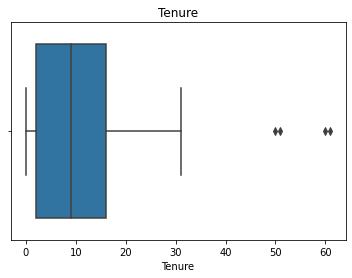

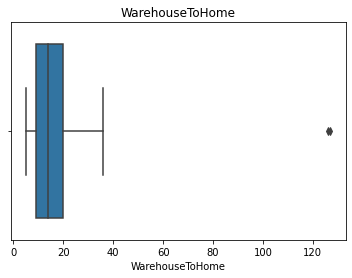

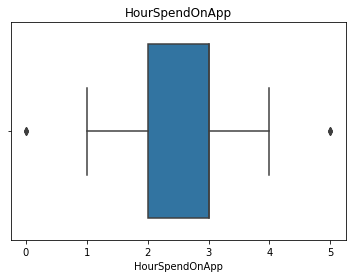

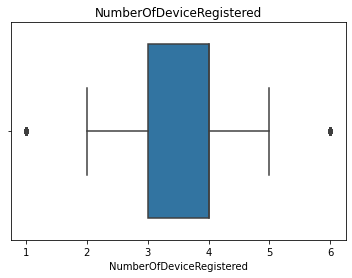

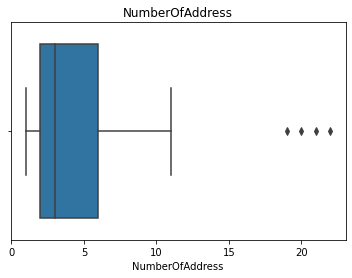

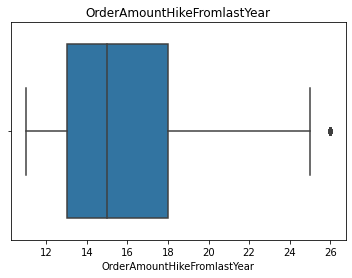

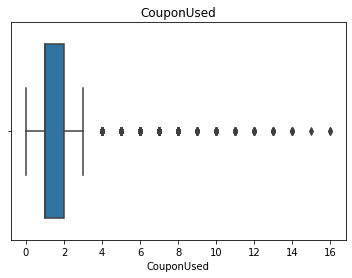

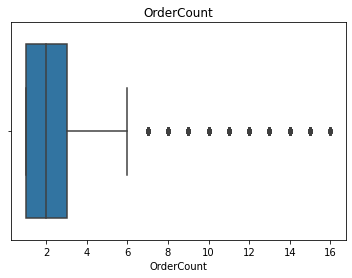

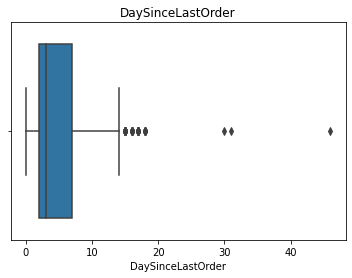

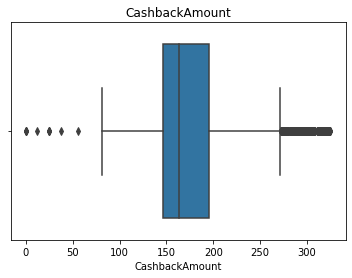

In [44]:
# Presence outliers through visualizations
for i in column_w_outlier:
    sns.boxplot(df[i])
    plt.title(i)
    plt.show()

In [45]:
# Handling outliers

for j in column_w_outlier:
    lower_range=Q1[j]-1.5*IQR[j]
    upper_range=Q3[j]+1.5*IQR[j]
    df[j]=np.where(df[j]>upper_range, upper_range, df[j])
    df[j]=np.where(df[j]<lower_range, lower_range, df[j])

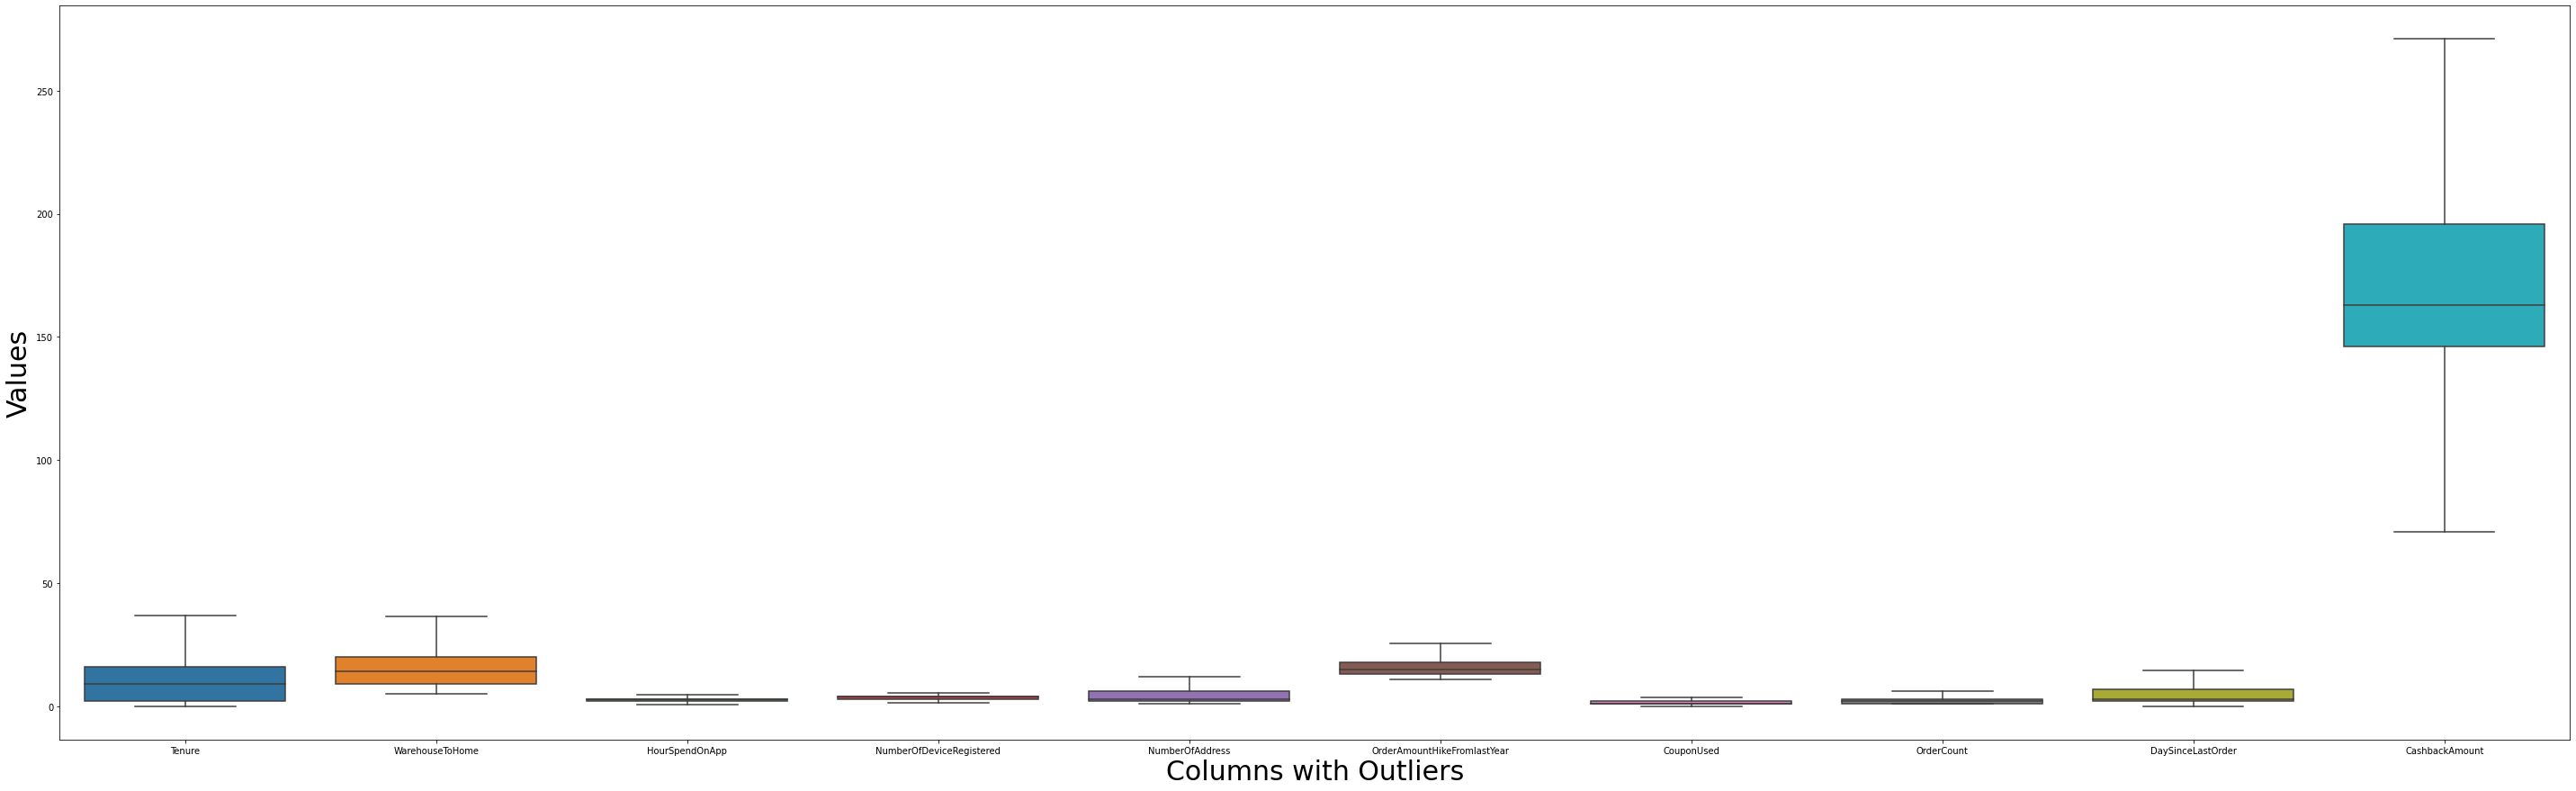

In [46]:
plt.figure(figsize=(50, 15))
sns.boxplot(data=df.drop(['Churn', 'CityTier', 'SatisfactionScore', 'Complain'], axis=1))
plt.xlabel('Columns with Outliers', size=30)
plt.ylabel('Values', size=30)
plt.show()

Outliers have been removed either by the upper range or the lower range

In [47]:
# Handling duplicate data
df.drop_duplicates(inplace=True)

In [48]:
df.duplicated().sum()

0

## EDA

In [291]:
# There's imbalance in the churn distribution
round(df['Churn'].value_counts()/df.shape[0]*100,2)

0    83.46
1    16.54
Name: Churn, dtype: float64

In [16]:
# Print the final number of unique values in each column
columns=['Column Name','Unique Data Count', 'Data Type']
value_desc=[]
for i in df.columns:
    value_desc.append([i, 
                      df[i].nunique(),
                      df[i].dtypes])
info_table1=pd.DataFrame(columns=columns, data=value_desc)
info_table1=info_table1.drop(0)
info_table1

,Column Name,Unique Data Count,Data Type
1,Tenure,33,float64
2,PreferredLoginDevice,3,object
3,CityTier,3,int64
4,WarehouseToHome,33,float64
5,PreferredPaymentMode,7,object
6,Gender,2,object
7,HourSpendOnApp,6,float64
8,NumberOfDeviceRegistered,6,float64
9,PreferedOrderCat,6,object
10,SatisfactionScore,5,int64


In [17]:
# Differentiate data by numerical data and categorical data
categ_data=df.select_dtypes(include='object')
numer_data=df.select_dtypes(include=['int64', 'float64'])

In [18]:
# Get each component from categorical data
for i in categ_data.columns:
    print(i)
    print()
    print(categ_data[i].value_counts())
    print()
    print()

PreferredLoginDevice

Mobile Phone    2483
Computer        1439
Phone           1096
Name: PreferredLoginDevice, dtype: int64


PreferredPaymentMode

Debit Card          2075
Credit Card         1331
E wallet             555
UPI                  356
COD                  322
CC                   247
Cash on Delivery     132
Name: PreferredPaymentMode, dtype: int64


Gender

Male      3018
Female    2000
Name: Gender, dtype: int64


PreferedOrderCat

Laptop & Accessory    1826
Mobile Phone          1118
Fashion                751
Mobile                 723
Grocery                364
Others                 236
Name: PreferedOrderCat, dtype: int64


MaritalStatus

Married     2640
Single      1530
Divorced     848
Name: MaritalStatus, dtype: int64




In [19]:
categ_data.describe().transpose()

,count,unique,top,freq
PreferredLoginDevice,5018,3,Mobile Phone,2483
PreferredPaymentMode,5018,7,Debit Card,2075
Gender,5018,2,Male,3018
PreferedOrderCat,5018,6,Laptop & Accessory,1826
MaritalStatus,5018,3,Married,2640


In [20]:
numer_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Churn,5018.0,0.165405,0.371582,0.0,0.0,0.0,0.0,1.0
Tenure,4787.0,10.170462,8.533689,0.0,2.0,9.0,16.0,37.0
CityTier,5018.0,1.658031,0.919002,1.0,1.0,1.0,3.0,3.0
WarehouseToHome,4799.0,15.512190,8.309215,5.0,9.0,13.0,20.0,36.5
HourSpendOnApp,4788.0,2.927736,0.722883,0.5,2.0,3.0,3.0,4.5
NumberOfDeviceRegistered,5018.0,3.693503,0.946507,1.5,3.0,4.0,4.0,5.5
SatisfactionScore,5018.0,3.023117,1.384106,1.0,2.0,3.0,4.0,5.0
NumberOfAddress,5018.0,4.182941,2.541270,1.0,2.0,3.0,6.0,12.0
Complain,5018.0,0.282583,0.450300,0.0,0.0,0.0,1.0,1.0
OrderAmountHikeFromlastYear,4774.0,15.697633,3.661347,11.0,13.0,15.0,18.0,25.5


In [21]:
# Grouping all numerical data by whether customers churning or not and aggregate them
gall=df.groupby('Churn').agg(['mean', 'std']).transpose()
gall

Churn                                      0           1
Tenure                      mean   11.451429    3.404199
                            std     8.400966    5.503016
CityTier                    mean    1.617956    1.860241
                            std     0.903345    0.969864
WarehouseToHome             mean   15.224257   17.044796
                            std     8.197584    8.726909
HourSpendOnApp              mean    2.923403    2.950000
                            std     0.728058    0.695714
NumberOfDeviceRegistered    mean    3.644102    3.942771
                            std     0.942303    0.928721
SatisfactionScore           mean    2.961557    3.333735
                            std     1.382342    1.351653
NumberOfAddress             mean    4.126791    4.466265
                            std     2.505674    2.697574
Complain                    mean    0.233286    0.531325
                            std     0.422973    0.499319
OrderAmountHikeFromlastYear mean   15.736476   15.509780
                            std     3.641158    3.754055
CouponUsed                  mean    1.473889    1.444242
                            std     1.091758    1.086063
OrderCount                  mean    2.589705    2.458231
                            std     1.762878    1.686383
DaySinceLastOrder           mean    4.760419    3.226573
                            std     3.527360    3.087574
CashbackAmount              mean  178.377268  160.531325
                            std    44.655056   35.785999

From data above we could summarize several things like, 
- churners get fewer cashback amount than non-churners 
- non-churners have more order counts than churners
- churners leave more complain than non-churners

In [22]:
# normality test
from scipy.stats import kstest

columns=['Column Name', 'P-value', 'Less Than Significance Value Or Not']
value=[]
for i in numer_data:
    res=kstest(df[i], 'norm')
    value.append([i,
                 res[1],
                 res[1]<0.05])
normal=pd.DataFrame(columns=columns, data=value)
normal

,Column Name,P-value,Less Than Significance Value Or Not
0,Churn,0.0,True
1,Tenure,NaN,False
2,CityTier,0.0,True
3,WarehouseToHome,NaN,False
4,HourSpendOnApp,NaN,False
5,NumberOfDeviceRegistered,0.0,True
6,SatisfactionScore,0.0,True
7,NumberOfAddress,0.0,True
8,Complain,0.0,True
9,OrderAmountHikeFromlastYear,NaN,False


In [23]:
normal['Less Than Significance Value Or Not'].value_counts()

False    7
True     7
Name: Less Than Significance Value Or Not, dtype: int64

In [24]:
# spearman method is used since some of the features are not normally distributed
numer_data.corr(method='spearman').sort_values(by='Churn', ascending=False)

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
Churn,1.000000,-0.398887,0.097598,0.079780,0.011189,0.112993,0.098945,0.038528,0.245939,-0.033653,-0.010202,-0.021338,-0.179458,-0.160254
Complain,0.245939,-0.037480,0.005105,0.051388,0.009744,-0.004496,-0.034282,-0.020320,1.000000,-0.011617,-0.003076,-0.007331,-0.043791,0.002986
NumberOfDeviceRegistered,0.112993,-0.025252,0.020817,0.024428,0.352892,1.000000,-0.012876,0.129164,-0.004496,0.096655,0.257706,0.253501,0.034968,0.206862
SatisfactionScore,0.098945,-0.020033,-0.005067,0.029653,0.038548,-0.012876,1.000000,0.039991,-0.034282,-0.023903,0.016716,0.000485,0.021642,-0.001008
CityTier,0.097598,-0.058836,1.000000,0.021131,-0.014332,0.020817,-0.005067,-0.019649,0.005105,-0.033730,0.020977,0.029997,0.007430,0.126478
WarehouseToHome,0.079780,-0.039861,0.021131,1.000000,0.081530,0.024428,0.029653,0.023781,0.051388,0.042015,0.020916,0.032702,0.034354,0.027300
NumberOfAddress,0.038528,0.287894,-0.019649,0.023781,0.182788,0.129164,0.039991,1.000000,-0.020320,0.045122,0.104823,0.067133,-0.081813,0.262656
HourSpendOnApp,0.011189,-0.005388,-0.014332,0.081530,1.000000,0.352892,0.038548,0.182788,0.009744,0.137891,0.315580,0.293160,0.110537,0.187562
CouponUsed,-0.010202,0.115894,0.020977,0.020916,0.315580,0.257706,0.016716,0.104823,-0.003076,0.066694,1.000000,0.714016,0.315666,0.322903
OrderCount,-0.021338,0.160821,0.029997,0.032702,0.293160,0.253501,0.000485,0.067133,-0.007331,0.057439,0.714016,1.000000,0.466946,0.380705


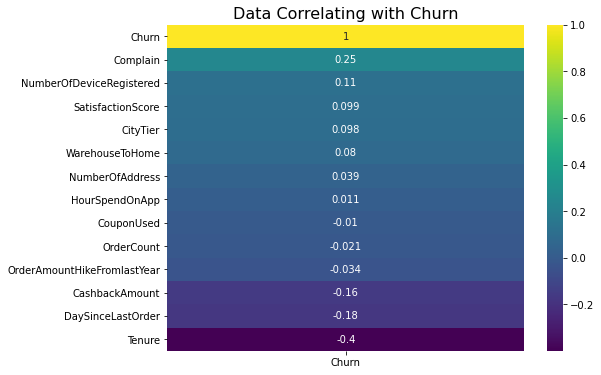

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(numer_data.corr(method='spearman')[['Churn']].sort_values(by='Churn', ascending=False), annot=True, cmap='viridis')
plt.title('Data Correlating with Churn', fontsize=16)
plt.show()

The most correlated feature after the churn itself is complain, it's make sense since mostly complain representing negative customer experience by that they decide to stop using and buying in the e-commerce. The second most correlated is number of device registered, could be assume that the increasing of devices they use there's likelihood that their commitment to stay login and using the e-commerce decrease. The third most correlated is satisfaction score, whether or not they satisfied will affecting their tendency to stay or not in buying and using in the e-commerce

### EDA : Purchase Pattern

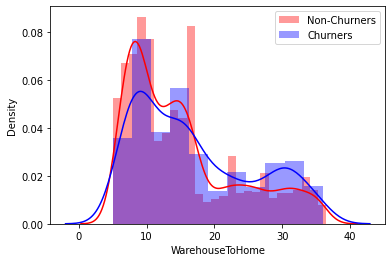

In [26]:
sns.distplot(df[df['Churn']==0]['WarehouseToHome'], color='red', label='Non-Churners')
sns.distplot(df[df['Churn']==1]['WarehouseToHome'], color='blue', label='Churners')

plt.legend()
plt.show()

In [27]:
w=pd.concat([df.groupby('WarehouseToHome')['Churn'].sum(), df['WarehouseToHome'].value_counts(), df.groupby('WarehouseToHome')['Churn'].sum()/df['WarehouseToHome'].value_counts()*100], axis=1)
w=w.reset_index()
w=w.rename(columns={'index':'Warehouse To Home', 'Churn':'Customers Churned', 'WarehouseToHome':'Total Customers', 0:'Percent of Total Customers'})
w

,Warehouse To Home,Customers Churned,Total Customers,Percent of Total Customers
0,5.0,1,8,12.500000
1,6.0,31,281,11.032028
2,7.0,45,373,12.064343
3,8.0,53,399,13.283208
4,9.0,73,496,14.717742
5,10.0,39,238,16.386555
6,11.0,28,207,13.526570
7,12.0,26,195,13.333333
8,13.0,28,214,13.084112
9,14.0,33,265,12.452830


The customer churn tendency is quite vary for warehouse to home distance, since there's no specific pattern. However, the peak of customer churning is happened at warehouse to home distance 9

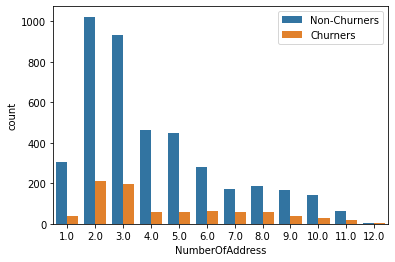

In [32]:
sns.countplot(x='NumberOfAddress', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.show()

In [36]:
na=pd.concat([df.groupby('NumberOfAddress')['Churn'].sum(), df['NumberOfAddress'].value_counts(), df.groupby('NumberOfAddress')['Churn'].sum()/df['NumberOfAddress'].value_counts()*100], axis=1)
na=na.reset_index()
na=na.rename(columns={'index':'Number Of Address', 'Churn':'Customers Churned', 'NumberOfAddress':'Total Customers', 0:'Percent of Total Customers'})
na

,Number Of Address,Customers Churned,Total Customers,Percent of Total Customers
0,1.0,37,340,10.882353
1,2.0,209,1232,16.964286
2,3.0,198,1133,17.475728
3,4.0,57,519,10.982659
4,5.0,60,509,11.787819
5,6.0,62,344,18.023256
6,7.0,59,233,25.321888
7,8.0,58,245,23.673469
8,9.0,41,208,19.711538
9,10.0,29,170,17.058824


People with 2 or 3 address tend to leave the e-commerce. The customer churn tend to decrease as the number of address increase, because they can manage the address that they want.  

According clarity-ventures, 'Sharing address-management advice with customers can generate greater loyalty. Customers who enjoy the convenience of using a custom address book on a company's website will be very unlikely to use a competitive company that doesn't offer the same service'  

Source : https://www.clarity-ventures.com/blog/the-importance-of-a-custom-address-book-for-ecommerce

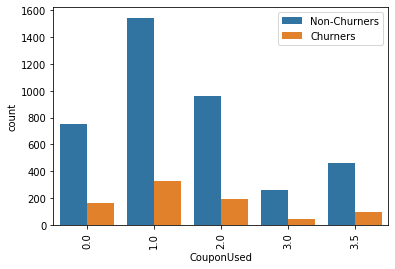

In [37]:
sns.countplot(x='CouponUsed', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.xticks(rotation=90)
plt.show()

Customers with one coupon received, tend to churn than the people with higher coupon used, this happen because probably they expect more coupon that offer discount or cashback or free delivery for example, given to them.   

According to coredna, 'For the vast majority of consumers, discovering discounts, coupons, and other deals is an integral part of the overall shopping experience.

Case in point, Hawk Incentives found that 97% of consumers (eCommerce and otherwise) say they look for deals as they shop—with 92% saying they are always on the lookout for promotional offers. Backing this data up, PRRI found that 92% of consumers used a coupon or otherwise took advantage of a discount or offer in 2017'  

Source: https://www.coredna.com/blogs/ecommerce-promotion-strategy

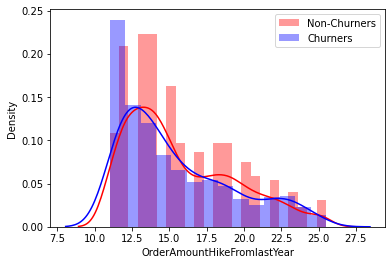

In [38]:
sns.distplot(df[df['Churn']==0]['OrderAmountHikeFromlastYear'], color='red', label='Non-Churners')
sns.distplot(df[df['Churn']==1]['OrderAmountHikeFromlastYear'], color='blue', label='Churners')

plt.legend()
plt.show()

In [39]:
oa=pd.concat([df.groupby('OrderAmountHikeFromlastYear')['Churn'].sum(), df['OrderAmountHikeFromlastYear'].value_counts(), df.groupby('OrderAmountHikeFromlastYear')['Churn'].sum()/df['OrderAmountHikeFromlastYear'].value_counts()*100], axis=1)
oa=oa.reset_index()
oa=oa.rename(columns={'index':'Order Amount Hike From last Year', 'Churn':'Customers Churned', 'OrderAmountHikeFromlastYear':'Total Customers', 0:'Percent of Total Customers'})
oa

,Order Amount Hike From last Year,Customers Churned,Total Customers,Percent of Total Customers
0,11.0,72,343,20.991254
1,12.0,131,653,20.061256
2,13.0,119,674,17.655786
3,14.0,102,659,15.477997
4,15.0,70,476,14.705882
5,16.0,56,297,18.855219
6,17.0,44,260,16.923077
7,18.0,46,289,15.916955
8,19.0,40,282,14.184397
9,20.0,27,214,12.616822


As the order amount hike from last year increase, the customer tendency to leave the e-commerce getting lower

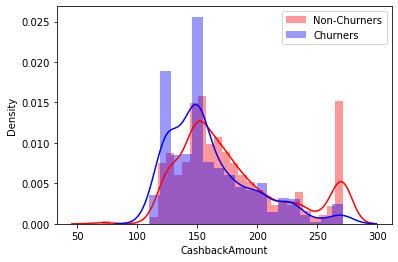

In [41]:
sns.distplot(df[df['Churn']==0]['CashbackAmount'], color='red', label='Non-Churners')
sns.distplot(df[df['Churn']==1]['CashbackAmount'], color='blue', label='Churners')

plt.legend()
plt.show()

People who get low-medium cashback amount tend to churn or leave the e-commerce

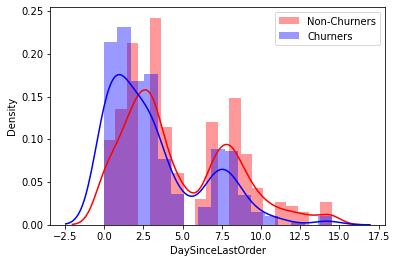

In [42]:
sns.distplot(df[df['Churn']==0]['DaySinceLastOrder'], color='red', label='Non-Churners')
sns.distplot(df[df['Churn']==1]['DaySinceLastOrder'], color='blue', label='Churners')

plt.legend()
plt.show()

People tend to churn from this e-commerce if they have just shop within 0 to 3 days. So, there's no e-commerce-related activity in these times

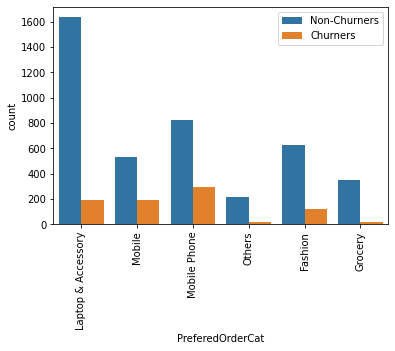

In [43]:
sns.countplot(x='PreferedOrderCat', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.xticks(rotation=90)
plt.show()

People mostly tend to leave the e-commerce mostly after they order mobile phone and tend to stay after they order laptop and accessory category

### EDA : Customer Behaviors

In [44]:
d=pd.concat([df.groupby('Complain')['Churn'].sum(), df['Complain'].value_counts(), df.groupby('Complain')['Churn'].sum()/df['Complain'].value_counts()*100], axis=1)
d=d.reset_index()
d=d.rename(columns={'index':'Complain', 'Churn':'Customers Churned', 'Complain':'Total Customers', 0:'Percent of Total Customers'})
d

,Complain,Customers Churned,Total Customers,Percent of Total Customers
0,0,389,3600,10.805556
1,1,441,1418,31.100141


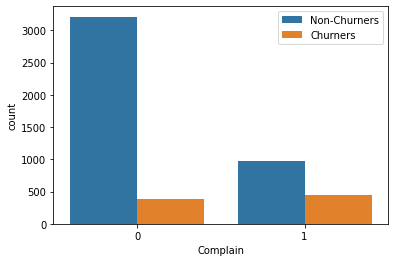

In [47]:
sns.countplot(x='Complain', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.show()

31% of customers did leave the e-commerce after leaving a complain, while there's only 11% customers leave the e-commerce without a complain

In [48]:
f=pd.concat([df.groupby('NumberOfDeviceRegistered')['Churn'].sum(), df['NumberOfDeviceRegistered'].value_counts(), df.groupby('NumberOfDeviceRegistered')['Churn'].sum()/df['NumberOfDeviceRegistered'].value_counts()*100], axis=1)
f=f.reset_index()
f=f.rename(columns={'index':'Number of Device Registered', 'Churn':'Customers Churned', 'NumberOfDeviceRegistered':'Total Customers', 0:'Percent of Total Customers'})
f

,Number of Device Registered,Customers Churned,Total Customers,Percent of Total Customers
0,1.5,19,215,8.837209
1,2.0,21,249,8.433735
2,3.0,217,1510,14.370861
3,4.0,340,2109,16.121385
4,5.0,181,790,22.911392
5,5.5,52,145,35.862069


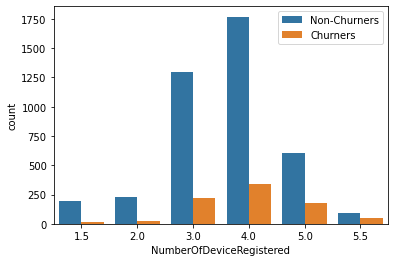

In [50]:
sns.countplot(x='NumberOfDeviceRegistered', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.show()

For 3 to 5 number of device registered there's high likelihood that the customer churning

In [32]:
c=pd.concat([df.groupby('SatisfactionScore')['Churn'].sum(), df['SatisfactionScore'].value_counts(), df.groupby('SatisfactionScore')['Churn'].sum()/df['SatisfactionScore'].value_counts()*100], axis=1)
c=c.reset_index()
c=c.rename(columns={'index':'Satisfaction Score', 'Churn':'Customers Churned', 'SatisfactionScore':'Total Customers', 0:'Percent of Total Customers'})
c

,Satisfaction Score,Customers Churned,Total Customers,Percent of Total Customers
0,1,123,1068,11.516854
1,2,74,586,12.627986
2,3,258,1485,17.373737
3,4,153,920,16.630435
4,5,222,959,23.149114


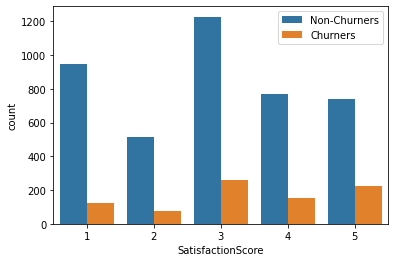

In [33]:
sns.countplot(x='SatisfactionScore', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.show()

In [34]:
s=df.groupby('SatisfactionScore')[['OrderCount']].count()
s

,OrderCount
SatisfactionScore,
1,1024
2,558
3,1413
4,871
5,911


Customers with high satisfaction score tend to leave the e-commerce than the customers with lower satisfaction score. Customer representations and order count representations is in a great deal of numbers for high satisfaction score, that's why there's likelihood of customer to churn

In [268]:
t=pd.concat([df.groupby('CityTier')['Churn'].sum(), df['CityTier'].value_counts(), df.groupby('CityTier')['Churn'].sum()/df['CityTier'].value_counts()*100], axis=1)
t=t.reset_index()
t=t.rename(columns={'index':'City Tier', 'Churn':'Customers Churned', 'CityTier':'Total Customers', 0:'Percent of Total Customers'})
t

,City Tier,Customers Churned,Total Customers,Percent of Total Customers
0,1,456,3270,13.944954
1,2,34,194,17.525773
2,3,340,1554,21.879022


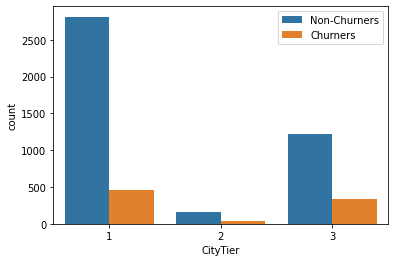

In [35]:
sns.countplot(x='CityTier', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.show()

In [270]:
o=df.groupby('CityTier')[['OrderCount']].count()
o

,OrderCount
CityTier,
1,3103
2,190
3,1484


The first city tier has the highest customer churning that inline with a great number of orders that have been made by people from this city. It also seen, that people from second tier have the lowest churning due to because they also made low order numbers

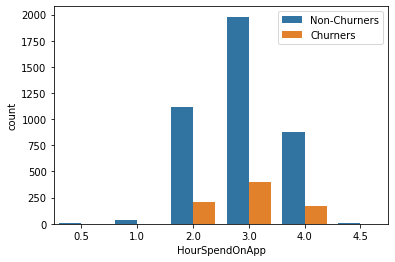

In [54]:
sns.countplot(x='HourSpendOnApp', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.show()

Most customers that churn spent around 3 hours to use the e-commerce app. This include the non-churners that have high representation in 3 hours. The churning happen maybe because customers get bored with the app or with the products offered in it

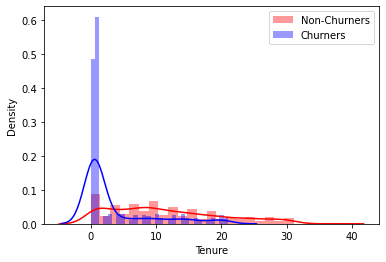

In [55]:
sns.distplot(df[df['Churn']==0]['Tenure'], color='red', label='Non-Churners')
sns.distplot(df[df['Churn']==1]['Tenure'], color='blue', label='Churners')

plt.legend()
plt.show()

Customer with low tenure has high spike in term of their tendency to churning from the e-commerce

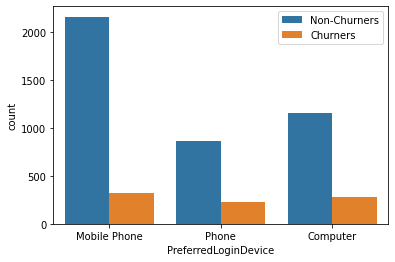

In [56]:
sns.countplot(x='PreferredLoginDevice', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.show()

In [57]:
df.groupby('PreferredLoginDevice')['Churn'].value_counts()

PreferredLoginDevice  Churn
Computer              0        1159
                      1         280
Mobile Phone          0        2164
                      1         319
Phone                 0         865
                      1         231
Name: Churn, dtype: int64

Most churn contributors is mobile phone user

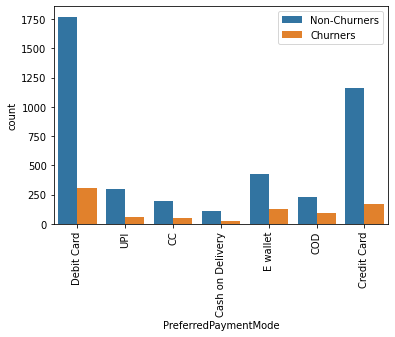

In [58]:
sns.countplot(x='PreferredPaymentMode', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.xticks(rotation=90)
plt.show()

People who churn and not churn tend to use debit card followed by credit card for their preffered payment mode

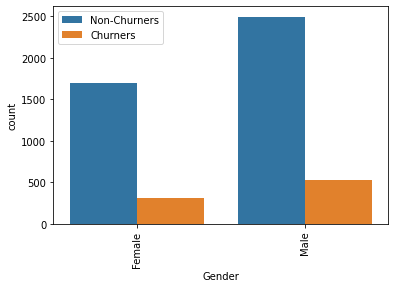

In [59]:
sns.countplot(x='Gender', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.xticks(rotation=90)
plt.show()

Male customers tend to leave the e-commerce more than female customers

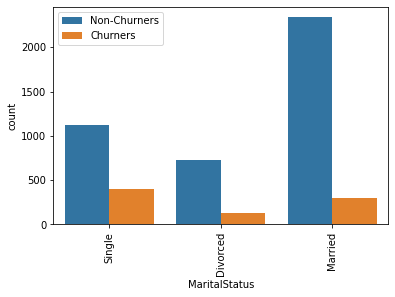

In [60]:
sns.countplot(x='MaritalStatus', data=df, hue='Churn')

plt.legend(['Non-Churners', 'Churners'])
plt.xticks(rotation=90)
plt.show()

The single customers is the highest in terms of leaving the e-commerce. The divorced customers may need many things provided easily by that they rely on e-commerce so their leaving tendency is low

In [64]:
df_subset=df[df['MaritalStatus']=='Divorced']

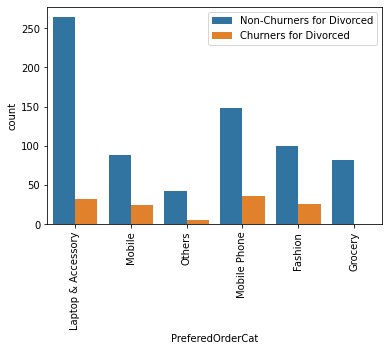

In [65]:
sns.countplot(x='PreferedOrderCat', data=df_subset, hue='Churn')

plt.legend(['Non-Churners for Divorced', 'Churners for Divorced'], loc=1)
plt.xticks(rotation=90)
plt.show()

Divorced people hasn't leave the e-commerce could be due to grocery shopping. Since grocery shopping is daily basic needs

**Summary:**
- Customers with one coupon received, tend to churn than the people with higher coupon used, this happen because probably they expect more coupon that offer discount or cashback or free delivery for example, given to them
- People who get low-medium cashback amount tend to churn or leave the e-commerce     
- People tend to churn from this e-commerce or have no e-commerce-related activity if they have just shop within 0 to 3 days 
- 31% of customers did leave the e-commerce after leaving a complain
- Customers with high satisfaction score tend to leave the e-commerce than the customers with lower satisfaction score. Customer representations and order count representations is in a great deal of numbers for high satisfaction score, that's why there's likelihood of customer to churn 
- Most customers that churn spent around 3 hours using the e-commerce app. The churning happen maybe because customers get bored with the app or with the products offered in it  
- The single customers is the highest in terms of leaving the e-commerce. The divorced customers may need many things provided easily by that they rely on e-commerce so their leaving tendency is low  

**Action:**
- Create a coupon that advantageous for customers could be based on special seasons, after bundling etc. A coupon that engaging enough for them so that they choose not to leave the e-commerce  
- Increase the cashback amount given directly or after several transactions  
- Give them notifications that beneficial to them like special price, discount, brand discount, new features, product recommendation etc, to make them open the e-commerce again. Ever better personalized notifications  
- Increase customer service, find out what mostly disappoint them through feedback could be in form of survey, this will reach also the non-complain customers but also leaving
- Add new feature related to satisfaction score that give insight why costumer leaving. It's important to retain customer that give high satisfaction score to maintain seller performance
- Give them interesting information through notification with a break an hour after they leave, like product recommendation  
- Learn about the competitors, maybe the single customers leave to competitors. Single and young people still like to explore things. Find out what competitors offers to them   

## Customers Segmentation

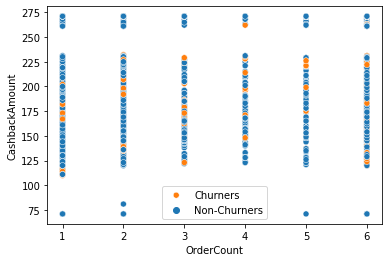

In [49]:
sns.scatterplot(x='OrderCount', y='CashbackAmount', data=df, hue='Churn')

plt.legend(['Churners', 'Non-Churners'])
plt.show()

It's quite vary customers tendency to churn if we look by the amount of orders they made and the cashback amount they attained. But mostly they were start churning in range cashback around 150 to 250

In [50]:
df[['OrderCount', 'CashbackAmount']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
OrderCount,4777.0,2.567302,1.750605,1.0,1.0,2.0,3.0,6.0
CashbackAmount,5018.0,175.425468,43.815099,71.0,146.0,164.0,197.0,271.0


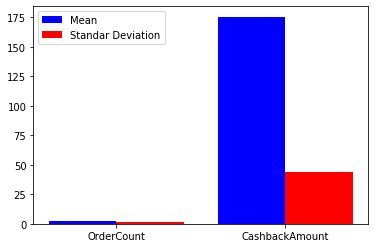

In [51]:
# Get the statistics
avg=df[['OrderCount', 'CashbackAmount']].describe().loc['mean']
std=df[['OrderCount', 'CashbackAmount']].describe().loc['std']
x_names=df[['OrderCount', 'CashbackAmount']].columns
x_ix=np.arange(df[['OrderCount', 'CashbackAmount']].shape[1])

# Plot the data
plt.bar(x_ix-0.2, avg, color='blue', label='Mean', width=0.4)
plt.bar(x_ix+0.2, std, color='red', label='Standar Deviation', width=0.4)
plt.xticks(x_ix, x_names)
plt.legend()
plt.show()

Cashback amount doesn't need to standardized, because it will change the value of the cashback amount for customer segmentation

In [52]:
X=df.copy()
X1=X[['OrderCount', 'CashbackAmount']]

In [53]:
X1.isna().sum()

OrderCount        241
CashbackAmount      0
dtype: int64

In [54]:
pipe=Pipeline([('imputer', SimpleImputer(strategy='mean'))])

In [55]:
transformer=ColumnTransformer([('pipe', pipe, ['OrderCount'])], remainder='passthrough')

In [56]:
X_preprocessed=transformer.fit_transform(X1)

In [57]:
X_preprocessed=pd.DataFrame(data=X_preprocessed,
                           index=X1.index,
                           columns=X1.columns)

In [58]:
X_preprocessed

,OrderCount,CashbackAmount
0,1.0,160.0
1,1.0,121.0
2,1.0,120.0
3,1.0,134.0
4,1.0,130.0
...,...,...
5623,2.0,224.0
5624,2.0,155.0
5626,2.0,225.0
5627,2.0,186.0


### K-Means Clustering

In [59]:
# Elbow Method
number_of_cluster = range(2,11)
clusterings = [KMeans(n_clusters = k).fit(X_preprocessed) for k in number_of_cluster]
centroids = [k.cluster_centers_ for k in clusterings]

In [60]:
# Within SS
D_k = [cdist(X_preprocessed, cent, 'euclidean') for cent in centroids] # distance from centroid
cIdx = [np.argmin(D, axis = 1) for D in D_k] # minimal distance
dist = [np.min(D, axis = 1) for D in D_k] 
avg_withinSS = [sum(d)/X1.shape[0] for d in dist] # minimal distance average

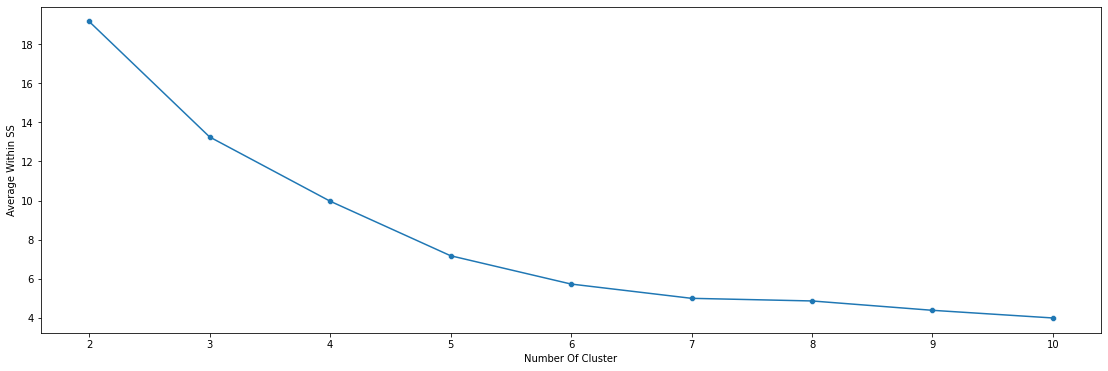

In [61]:
plt.figure(figsize=(19,6))
sns.lineplot(number_of_cluster, avg_withinSS)
sns.scatterplot(number_of_cluster, avg_withinSS)
plt.xticks(number_of_cluster)
plt.xlabel('Number Of Cluster')
plt.ylabel('Average Within SS')
plt.show()

Seems like the best number of clusters are between 5, 6, and 7

In [62]:
# silhouette score
s_score = []

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_preprocessed)
    labels = kmeans.labels_
    s_score.append(silhouette_score(X_preprocessed, labels, metric = 'euclidean'))

In [63]:
s_score

[0.6659652356447032,
 0.5796188314639451,
 0.5636895427335303,
 0.5869951710377317,
 0.6042970709700479,
 0.5865518559789239,
 0.5927117944350718,
 0.5524978888664637,
 0.5528751586360247]

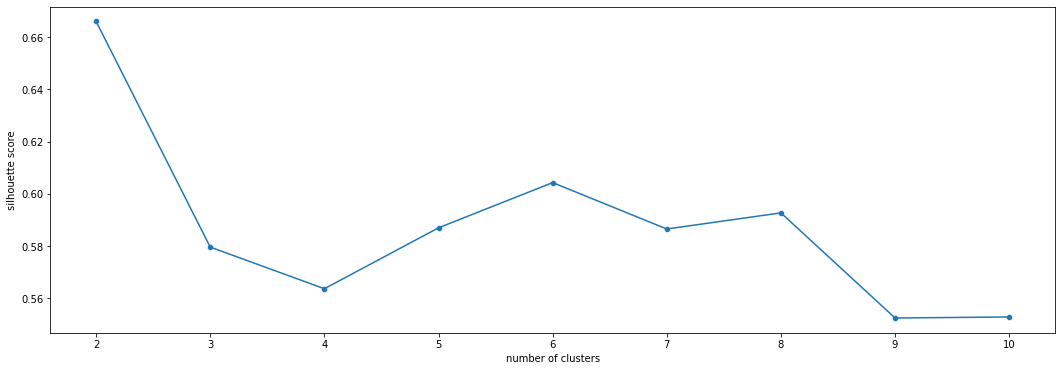

In [64]:
plt.figure(figsize=(18,6))
sns.lineplot(number_of_cluster, s_score)
sns.scatterplot(number_of_cluster, s_score)
plt.xticks(number_of_cluster)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.show()

from silhouette score, the best number of cluster is also 6. So, the best number of cluster that going to be used is 6

In [65]:
kmeans=KMeans(n_clusters=6)
kmeans.fit(X_preprocessed)

KMeans(n_clusters=6)

In [66]:
X[['OrderCount', 'CashbackAmount']]=X_preprocessed.copy()

In [67]:
X['Cluster']=kmeans.labels_

In [68]:
X['Cluster'].nunique()

6

In [69]:
X.groupby('Cluster')[['OrderCount', 'CashbackAmount']].mean()

,OrderCount,CashbackAmount
Cluster,,
0,3.020802,196.350669
1,1.675978,125.697207
2,3.474622,268.304029
3,2.351978,149.660300
4,3.086559,228.970803
5,2.664070,171.021422


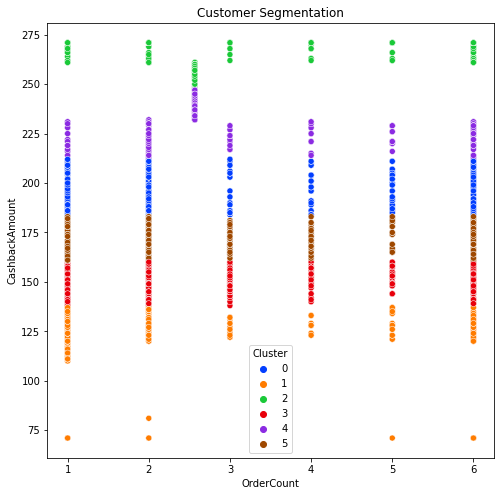

In [70]:
plt.figure(figsize = (8,8))
sns.scatterplot(x = 'OrderCount', y = 'CashbackAmount', data = X, hue='Cluster', palette='bright')
plt.title('Customer Segmentation')
plt.show()

### Agglomerative Clustering

In [71]:
from scipy.cluster.hierarchy import ward

In [72]:
agg_ward=AgglomerativeClustering(n_clusters=6,linkage='ward')
X['Ward']=agg_ward.fit_predict(X_preprocessed)

In [73]:
X.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,...,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Cluster,Ward
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3.0,Laptop & Accessory,...,Single,9.0,1,11.0,1.0,1.0,5.0,160.0,3,0
1,1,NaN,Phone,1,8.0,UPI,Male,3.0,4.0,Mobile,...,Single,7.0,1,15.0,0.0,1.0,0.0,121.0,1,4
2,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4.0,Mobile,...,Single,6.0,1,14.0,0.0,1.0,3.0,120.0,1,4
3,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4.0,Laptop & Accessory,...,Single,8.0,0,23.0,0.0,1.0,3.0,134.0,1,1
4,1,0.0,Phone,1,12.0,CC,Male,NaN,3.0,Mobile,...,Single,3.0,0,11.0,1.0,1.0,3.0,130.0,1,4


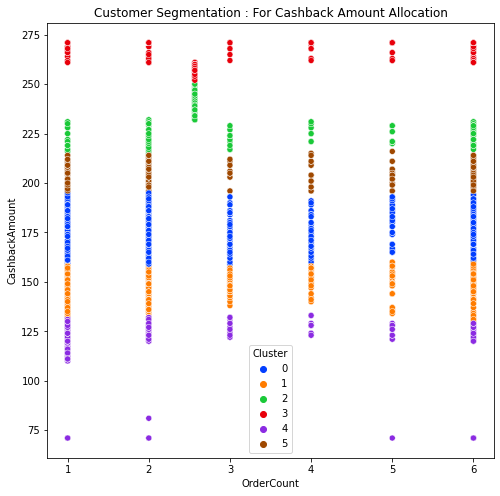

In [74]:
plt.figure(figsize = (8,8))
sns.scatterplot(x = 'OrderCount', y = 'CashbackAmount', data = X, hue='Ward', palette='bright')
plt.title('Customer Segmentation : For Cashback Amount Allocation')
plt.legend(title='Cluster')
plt.show()

Since the dataset is quite small, only around 5000 rows. The dataset is numerical variable. Also, agglomerative result tend to be consistent rather K-Means. I decide to use the agglomerative clustering result in term of cashback amount allocation

## Customer Churning

Since we want to dig out about customer churning in an e-commerce, the type of churn is non-contractual churn. It's when customer just stop buying a product in the e-commerce and there's no contract or term that bind the customer with the e-commerce

TP : Customers predicted churning, actually churning   
TN : Customers not predicted churning, actually not churning  
FP : Customers predicted churning, actually not churning  
FN : Customers predicted not churning, actually churning   


From above conditions, the highest issue is the FN, since we already allocated cashback to these customers. Company especially loss if the allocated cashback is huge and the customer decided to leave the e-commerce. So, the evaluation metric that going to used to solve this problem is recall. Recall tells us how many we correctly identified acually customer churn

In [75]:
X[(X['Churn']==1) & (X['Ward']==3)]

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,...,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Cluster,Ward
10,1,4.0,Mobile Phone,1,18.0,Cash on Delivery,Female,2.0,3.0,Others,...,Divorced,2.0,0,NaN,3.5,6.000000,8.0,271.0,2,3
443,1,18.0,Mobile Phone,1,8.0,Credit Card,Male,3.0,3.0,Others,...,Divorced,6.0,1,NaN,1.0,1.000000,4.0,271.0,2,3
470,1,20.0,Mobile Phone,1,8.0,Debit Card,Male,2.0,3.0,Others,...,Single,8.0,1,NaN,3.5,6.000000,8.0,271.0,2,3
624,1,15.0,Mobile Phone,3,8.0,E wallet,Female,2.0,5.0,Others,...,Divorced,2.0,0,NaN,3.5,6.000000,9.0,271.0,2,3
788,1,8.0,Mobile Phone,3,8.0,E wallet,Female,3.0,5.0,Others,...,Single,3.0,1,16.0,NaN,1.000000,11.0,271.0,2,3
1390,1,4.0,Mobile Phone,1,18.0,Cash on Delivery,Female,2.0,3.0,Others,...,Married,2.0,0,NaN,1.0,6.000000,8.0,271.0,2,3
1913,1,18.0,Mobile Phone,1,8.0,Credit Card,Male,3.0,3.0,Others,...,Married,6.0,1,NaN,1.0,1.000000,4.0,271.0,2,3
2094,1,15.0,Mobile Phone,3,8.0,E wallet,Female,2.0,5.0,Others,...,Married,2.0,0,NaN,3.0,6.000000,9.0,271.0,2,3
2825,1,5.0,Mobile Phone,1,19.0,Cash on Delivery,Female,3.0,4.0,Others,...,Divorced,3.0,0,NaN,3.5,6.000000,9.0,271.0,2,3
3125,1,1.0,Mobile Phone,1,22.0,Credit Card,Male,3.0,4.0,Fashion,...,Divorced,9.0,1,13.0,NaN,6.000000,8.0,261.0,2,3


For example like this, there are 24 people who choose to leave after receive high cashback amount in range 240 to 275

In [76]:
X[(X['Churn']==1) & (X['Ward']==2)]

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,...,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Cluster,Ward
146,1,10.0,Computer,1,35.0,Debit Card,Male,2.0,3.0,Fashion,...,Divorced,2.0,1,12.0,3.5,6.000000,NaN,218.0,4,2
310,1,0.0,Mobile Phone,1,21.0,Credit Card,Male,2.0,3.0,Fashion,...,Divorced,8.0,1,12.0,0.0,2.567302,7.0,236.0,4,2
581,1,3.0,Computer,3,30.0,Debit Card,Female,3.0,1.5,Grocery,...,Single,5.0,1,16.0,1.0,2.567302,0.0,232.0,4,2
688,1,2.0,Computer,1,8.0,Debit Card,Male,2.0,3.0,Grocery,...,Married,8.0,0,11.0,3.5,6.000000,NaN,222.0,4,2
713,1,5.0,Computer,3,18.0,Debit Card,Male,2.0,3.0,Grocery,...,Single,1.0,1,12.0,3.5,2.567302,14.0,238.0,4,2
850,1,18.0,Mobile Phone,3,19.0,E wallet,Male,2.0,1.5,Grocery,...,Single,7.0,1,17.0,2.0,2.567302,8.0,237.0,4,2
1098,1,10.0,Computer,3,15.0,Debit Card,Male,2.0,5.0,Grocery,...,Married,8.0,0,11.0,1.0,6.000000,NaN,229.0,4,2
1616,1,10.0,Computer,1,35.0,Debit Card,Male,2.0,3.0,Fashion,...,Married,2.0,1,12.0,3.5,6.000000,NaN,218.0,4,2
1780,1,0.0,Mobile Phone,1,21.0,Credit Card,Male,2.0,3.0,Fashion,...,Married,8.0,1,12.0,3.0,2.567302,7.0,236.0,4,2
2158,1,2.0,Computer,1,8.0,Debit Card,Male,2.0,3.0,Grocery,...,Married,8.0,0,11.0,3.5,6.000000,NaN,222.0,4,2


There are 59 people who churn after they receive cashback amount in range 213 to 235

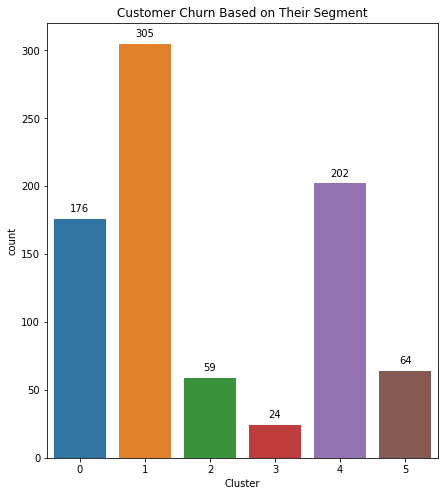

In [113]:
plt.figure(figsize=(7, 8))
splot=sns.countplot(x='Ward', data=X[X['Churn']==1])
plt.title('Customer Churn Based on Their Segment')
plt.xlabel('Cluster')
for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

### Preprocessing

In [77]:
transformer=ColumnTransformer([('onehot',OneHotEncoder(drop='first'), ['PreferredLoginDevice', 'Gender', 'MaritalStatus']),
                               ('binary',ce.BinaryEncoder(), ['PreferredPaymentMode', 'PreferedOrderCat']),
                               ('imputer', SimpleImputer(strategy='mean'), ['WarehouseToHome', 'Tenure', 'HourSpendOnApp', 'CouponUsed', 'OrderAmountHikeFromlastYear', 'DaySinceLastOrder', 'OrderCount']),
                               ('scaler', StandardScaler(), ['CashbackAmount'])
                              ], remainder='passthrough')

In [78]:
# Testing the transformer
transformer.fit_transform(df)

array([[1., 0., 0., ..., 2., 9., 1.],
       [0., 1., 1., ..., 3., 7., 1.],
       [0., 1., 1., ..., 3., 6., 1.],
       ...,
       [1., 0., 1., ..., 5., 6., 0.],
       [1., 0., 1., ..., 4., 3., 1.],
       [1., 0., 1., ..., 3., 4., 0.]])

### Splitting Data

In [79]:
X=df.drop('Churn', axis=1)
y=df['Churn']

In [80]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, stratify=y, random_state=2020)

### Model Benchmark & Evaluation Metric

In [81]:
def evaluate_model(models, scoring):
    model_name=[]
    scores_mean=[]
    scores_std=[]
    recall=[]
    for name, model in models:
        model=model
        estimator=Pipeline([('transformer', transformer),
                           ('model', model)])
        estimator.fit(X_train, y_train)
        skfold=StratifiedKFold(n_splits=5)
        score=cross_val_score(estimator, X_train, y_train, scoring=scoring, cv=skfold).mean()
        std=cross_val_score(estimator, X_train, y_train, scoring=scoring, cv=skfold).std()
        scores_mean.append(score)
        scores_std.append(std)
        recall.append(recall_score(y_test, estimator.predict(X_test)))
        model_name.append(name)
        
    return pd.DataFrame({'Name':model_name, 'score_mean':scores_mean, 'score_std':scores_std, 'recall_score':recall})

In [82]:
models=[['LogisticRegression', LogisticRegression()],
       ['DecisionTree', DecisionTreeClassifier()],
       ['RandomForest', RandomForestClassifier()],
       ['KNeighbours', KNeighborsClassifier()]]

In [83]:
evaluate_model(models, 'recall')

,Name,score_mean,score_std,recall_score
0,LogisticRegression,0.497406,0.037337,0.534137
1,DecisionTree,0.741836,0.042807,0.787149
2,RandomForest,0.676393,0.028846,0.738956
3,KNeighbours,0.521515,0.053559,0.566265


At initial stage the selected model is decision tree

#### Feature Selection

In [84]:
dt=DecisionTreeClassifier()
select=SelectPercentile(percentile=50)
rfe=RFE(DecisionTreeClassifier())

In [85]:
estimator=Pipeline([('transformer', transformer),
                    ('select', rfe),
                    ('model', dt)])

skfold=StratifiedKFold(n_splits=5)

In [86]:
hyperparam_space={'select':[select, rfe]}

In [87]:
grid_search=GridSearchCV(estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    n_jobs=-1,
    scoring='recall')

In [88]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PreferredLoginDevice',
                                                                          'Gender',
                                                                          'MaritalStatus']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['PreferredPaymentMode',
                                                    

In [89]:
pd.DataFrame(grid_search.cv_results_)[['param_select', 'mean_test_score', 'std_test_score']]

,param_select,mean_test_score,std_test_score
0,SelectPercentile(percentile=50),0.710875,0.039278
1,RFE(estimator=DecisionTreeClassifier()),0.753949,0.039717


In [90]:
grid_search.best_score_

0.7539493073975833

In [91]:
grid_search.best_params_

{'select': RFE(estimator=DecisionTreeClassifier())}

In [92]:
grid_search.best_estimator_.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferredLoginDevice',
                                                   'Gender', 'MaritalStatus']),
                                                 ('binary', BinaryEncoder(),
                                                  ['PreferredPaymentMode',
                                                   'PreferedOrderCat']),
                                                 ('imputer', SimpleImputer(),
                                                  ['WarehouseToHome', 'Tenure',
                                                   'HourSpendOnApp',
                                                   'CouponUsed',
                                                   'OrderAmountHikeFromlastYear',
               

In [93]:
recall_score(y_test,grid_search.best_estimator_.predict(X_test))

0.8353413654618473

The best feature selection method is RFE. With increasing of recall score from 79% to 84%

#### Handling Imbalance

In [244]:
dt=DecisionTreeClassifier()
under1=NearMiss()
under=RandomOverSampler()
over1=SMOTE()
over=RandomUnderSampler()

In [245]:
estimator=Pipeline([('transformer', transformer),
                    ('select', rfe),
                    ('balance', over1),
                    ('model', dt)])

skfold=StratifiedKFold(n_splits=5)

In [246]:
hyperparam_space={'balance':[over,under, under1, over1]}

In [254]:
grid_search1=GridSearchCV(estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    n_jobs=-1,
    scoring='recall')

In [255]:
grid_search1.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PreferredLoginDevice',
                                                                          'Gender',
                                                                          'MaritalStatus']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['PreferredPaymentMode',
                                                    

In [256]:
pd.DataFrame(grid_search1.cv_results_)[['param_balance', 'mean_test_score', 'std_test_score']]

,param_balance,mean_test_score,std_test_score
0,RandomUnderSampler(),0.858945,0.028623
1,RandomOverSampler(),0.728102,0.023526
2,NearMiss(),0.848571,0.045027
3,SMOTE(),0.719496,0.027582


In [257]:
grid_search1.best_score_

0.8589448865310935

In [258]:
grid_search1.best_params_

{'balance': RandomUnderSampler()}

In [259]:
grid_search1.best_estimator_.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferredLoginDevice',
                                                   'Gender', 'MaritalStatus']),
                                                 ('binary', BinaryEncoder(),
                                                  ['PreferredPaymentMode',
                                                   'PreferedOrderCat']),
                                                 ('imputer', SimpleImputer(),
                                                  ['WarehouseToHome', 'Tenure',
                                                   'HourSpendOnApp',
                                                   'CouponUsed',
                                                   'OrderAmountHikeFromlastYear',
               

In [260]:
recall_score(y_test,grid_search1.best_estimator_.predict(X_test))

0.8755020080321285

There was an increase of recall score before handling imbalance dataset is 84% now 88%

In [120]:
def evaluate_model2(models, scoring):
    model_name=[]
    scores_mean=[]
    scores_std=[]
    recall=[]
    for name, model in models:
        model=model
        estimator=Pipeline([('transformer', transformer),
                    ('select', rfe),
                    ('balance', over),
                    ('model', model)])
        estimator.fit(X_train, y_train)
        skfold=StratifiedKFold(n_splits=5)
        score=cross_val_score(estimator, X_train, y_train, scoring=scoring, cv=skfold).mean()
        std=cross_val_score(estimator, X_train, y_train, scoring=scoring, cv=skfold).std()
        scores_mean.append(score)
        scores_std.append(std)
        recall.append(recall_score(y_test, estimator.predict(X_test)))
        model_name.append(name)
        
    return pd.DataFrame({'Name':model_name, 'score_mean':scores_mean, 'score_std':scores_std, 'recall_score':recall})

In [121]:
evaluate_model2(models, 'recall')

,Name,score_mean,score_std,recall_score
0,LogisticRegression,0.798615,0.042754,0.807229
1,DecisionTree,0.845167,0.044524,0.887550
2,RandomForest,0.886369,0.016027,0.903614
3,KNeighbours,0.820984,0.062765,0.863454


After doing feature selection using estimator decision tree and handling imbalance dataset, Random Forest Classifier is the selected model

## Model Performance

In [261]:
rf=RandomForestClassifier()
balance=RandomUnderSampler()

In [262]:
estimator=Pipeline([('transformer', transformer),
                    ('select', rfe),
                    ('balance', balance),
                    ('model', rf)])

In [263]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferredLoginDevice',
                                                   'Gender', 'MaritalStatus']),
                                                 ('binary', BinaryEncoder(),
                                                  ['PreferredPaymentMode',
                                                   'PreferedOrderCat']),
                                                 ('imputer', SimpleImputer(),
                                                  ['WarehouseToHome', 'Tenure',
                                                   'HourSpendOnApp',
                                                   'CouponUsed',
                                                   'OrderAmountHikeFromlastYear',
               

In [264]:
y_pred=estimator.predict(X_test)

In [265]:
recall_score(y_test, y_pred)

0.8835341365461847

In [266]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1257
           1       0.60      0.88      0.72       249

    accuracy                           0.89      1506
   macro avg       0.79      0.88      0.82      1506
weighted avg       0.91      0.89      0.89      1506



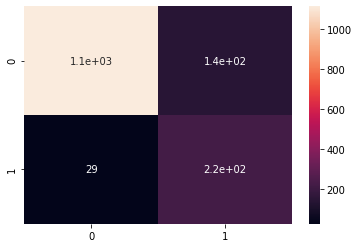

In [267]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

plt.show()

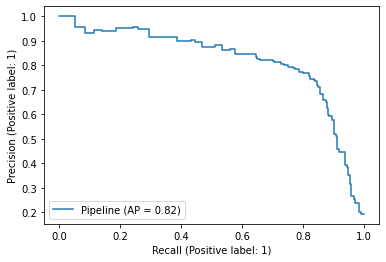

In [268]:
plot_precision_recall_curve(estimator, X_test, y_test)

## Hyperparameter Tunning

In [158]:
hyperparam_space = {
        'model__criterion' : ['entropy','gini'],
        'model__min_samples_leaf' : [1,5,10,15,20],
        'model__min_samples_split' : [2,5,10,15,20],
        'model__max_depth' : [5,6,7,9,11,13,15]
        }

In [159]:
estimator=Pipeline([('transformer', transformer),
                    ('select', rfe),
                    ('balance', balance),
                    ('model', rf)])

In [160]:
skfold=StratifiedKFold(n_splits=5)

In [163]:
grid=GridSearchCV(estimator,
                   param_grid=hyperparam_space,
                   cv=skfold,
                   scoring='recall',
                   n_jobs=-1)

In [164]:
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PreferredLoginDevice',
                                                                          'Gender',
                                                                          'MaritalStatus']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['PreferredPaymentMode',
                                                    

In [165]:
grid.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 13,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2}

In [166]:
grid.best_score_

0.8984674329501916

In [167]:
grid.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferredLoginDevice',
                                                   'Gender', 'MaritalStatus']),
                                                 ('binary', BinaryEncoder(),
                                                  ['PreferredPaymentMode',
                                                   'PreferedOrderCat']),
                                                 ('imputer', SimpleImputer(),
                                                  ['WarehouseToHome', 'Tenure',
                                                   'HourSpendOnApp',
                                                   'CouponUsed',
                                                   'OrderAmountHikeFromlastYear',
               

In [168]:
recall_score(y_test, grid.best_estimator_.predict(X_test))

0.9116465863453815

In [169]:
print(classification_report(y_test, grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1257
           1       0.59      0.91      0.72       249

    accuracy                           0.88      1506
   macro avg       0.79      0.89      0.82      1506
weighted avg       0.92      0.88      0.89      1506



<AxesSubplot:>

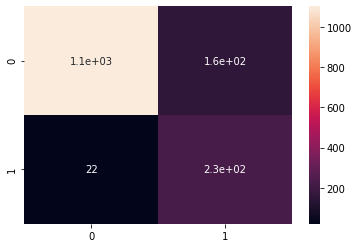

In [170]:
sns.heatmap(confusion_matrix(y_test,grid.best_estimator_.predict(X_test)), annot=True)

## Before VS After Tunning

In [189]:
# before
grid_search1.best_estimator_.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferredLoginDevice',
                                                   'Gender', 'MaritalStatus']),
                                                 ('binary', BinaryEncoder(),
                                                  ['PreferredPaymentMode',
                                                   'PreferedOrderCat']),
                                                 ('imputer', SimpleImputer(),
                                                  ['WarehouseToHome', 'Tenure',
                                                   'HourSpendOnApp',
                                                   'CouponUsed',
                                                   'OrderAmountHikeFromlastYear',
               

In [190]:
recall_score(y_test,grid_search1.best_estimator_.predict(X_test))

0.8835341365461847

In [191]:
print(classification_report(y_test, grid_search1.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1257
           1       0.46      0.88      0.60       249

    accuracy                           0.81      1506
   macro avg       0.72      0.84      0.74      1506
weighted avg       0.89      0.81      0.83      1506



In [272]:
# after
grid.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferredLoginDevice',
                                                   'Gender', 'MaritalStatus']),
                                                 ('binary', BinaryEncoder(),
                                                  ['PreferredPaymentMode',
                                                   'PreferedOrderCat']),
                                                 ('imputer', SimpleImputer(),
                                                  ['WarehouseToHome', 'Tenure',
                                                   'HourSpendOnApp',
                                                   'CouponUsed',
                                                   'OrderAmountHikeFromlastYear',
               

In [273]:
recall_score(y_test, grid.best_estimator_.predict(X_test))

0.9116465863453815

In [274]:
print(classification_report(y_test, grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1257
           1       0.60      0.91      0.72       249

    accuracy                           0.88      1506
   macro avg       0.79      0.89      0.82      1506
weighted avg       0.92      0.88      0.89      1506



The recall score, after tunning increase 3% from 88% to 91%

## Model Properties : Feature Importances

In [192]:
pd.DataFrame(grid.best_estimator_[3].feature_importances_)

,0
0,0.023378
1,0.038080
2,0.027844
3,0.098925
4,0.258408
5,0.072619
6,0.075952
7,0.041292
8,0.125069
9,0.046904


Number of features reduces to 13 features from 19 features after doing RFE feature selection

In [193]:
support=grid.best_estimator_.named_steps['select'].support_

In [194]:
grid.best_estimator_[0].transformers_[0][1].get_feature_names()

array(['x0_Mobile Phone', 'x0_Phone', 'x1_Male', 'x2_Married',
       'x2_Single'], dtype=object)

In [195]:
grid.best_estimator_[0].transformers_[1][1].get_feature_names()

['PreferredPaymentMode_0',
 'PreferredPaymentMode_1',
 'PreferredPaymentMode_2',
 'PreferredPaymentMode_3',
 'PreferedOrderCat_0',
 'PreferedOrderCat_1',
 'PreferedOrderCat_2',
 'PreferedOrderCat_3']

In [196]:
features=list(grid.best_estimator_[0].transformers_[0][1].get_feature_names())+grid.best_estimator_[0].transformers_[1][1].get_feature_names()+['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

In [197]:
features=list(np.array(features)[support])

In [198]:
features

['x1_Male',
 'x2_Single',
 'PreferedOrderCat_2',
 'Tenure',
 'CityTier',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'NumberOfAddress',
 'Complain',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount']

In [199]:
importance_tab=pd.DataFrame(grid.best_estimator_[3].feature_importances_,
                           columns=['imp'], index=features)

In [200]:
importance_tab

,imp
x1_Male,0.023378
x2_Single,0.038080
PreferedOrderCat_2,0.027844
Tenure,0.098925
CityTier,0.258408
NumberOfDeviceRegistered,0.072619
SatisfactionScore,0.075952
NumberOfAddress,0.041292
Complain,0.125069
CouponUsed,0.046904


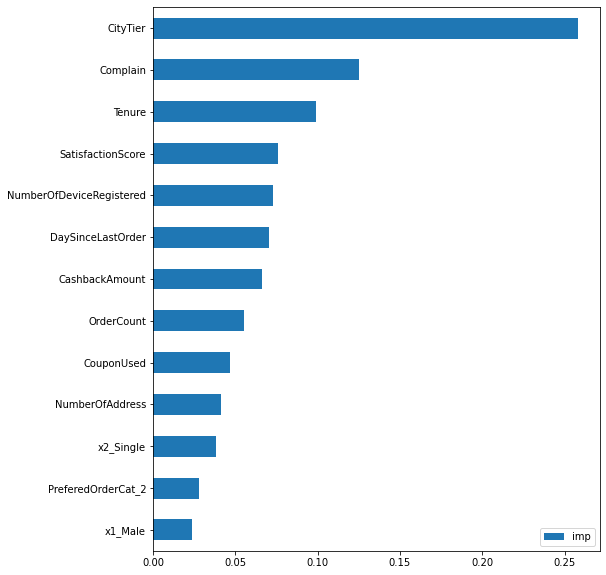

In [201]:
importance_tab.sort_values('imp').plot(kind='barh', figsize=(8, 10))

plt.show()

The most impacting column to whether they leave the e-commerce or not is complain. Like mentioned before complain related to negative customer experience

## Saving Model

In [275]:
grid.best_estimator_.fit(X,y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferredLoginDevice',
                                                   'Gender', 'MaritalStatus']),
                                                 ('binary', BinaryEncoder(),
                                                  ['PreferredPaymentMode',
                                                   'PreferedOrderCat']),
                                                 ('imputer', SimpleImputer(),
                                                  ['WarehouseToHome', 'Tenure',
                                                   'HourSpendOnApp',
                                                   'CouponUsed',
                                                   'OrderAmountHikeFromlastYear',
               

In [276]:
filename='modelChurn.sav'

In [277]:
pickle.dump(grid.best_estimator_, open(filename,'wb'))

In [278]:
loaded_model=pickle.load(open(filename, 'rb'))

In [279]:
loaded_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [280]:
loaded_model.predict_proba(X_test)

array([[0.83687309, 0.16312691],
       [0.90542743, 0.09457257],
       [0.92277535, 0.07722465],
       ...,
       [0.86754049, 0.13245951],
       [0.89447619, 0.10552381],
       [0.91371535, 0.08628465]])

## Prediction

In [286]:
df

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3.0,Laptop & Accessory,2,Single,9.0,1,11.0,1.0,1.0,5.0,160.0
1,1,NaN,Phone,1,8.0,UPI,Male,3.0,4.0,Mobile,3,Single,7.0,1,15.0,0.0,1.0,0.0,121.0
2,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4.0,Mobile,3,Single,6.0,1,14.0,0.0,1.0,3.0,120.0
3,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4.0,Laptop & Accessory,5,Single,8.0,0,23.0,0.0,1.0,3.0,134.0
4,1,0.0,Phone,1,12.0,CC,Male,NaN,3.0,Mobile,5,Single,3.0,0,11.0,1.0,1.0,3.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5623,0,5.0,Computer,1,12.0,Credit Card,Male,4.0,4.0,Laptop & Accessory,5,Single,2.0,0,20.0,2.0,2.0,NaN,224.0
5624,0,1.0,Mobile Phone,3,12.0,UPI,Female,2.0,5.0,Mobile Phone,3,Single,2.0,0,19.0,2.0,2.0,1.0,155.0
5626,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5.0,Fashion,5,Married,6.0,0,16.0,1.0,2.0,NaN,225.0
5627,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2.0,Laptop & Accessory,4,Married,3.0,1,21.0,1.0,2.0,4.0,186.0


In [287]:
df_pred=pd.DataFrame({
    'Tenure' : [0],
    'PreferredLoginDevice' : ['Mobile Phone'],
    'CityTier' : [1],
    'WarehouseToHome' : [6],
    'PreferredPaymentMode' : ['Credit Card'],
    'Gender' : ['Male'],
    'HourSpendOnApp' : [3],
    'NumberOfDeviceRegistered' : [3],
    'PreferedOrderCat' : ['Mobile Phone'],
    'SatisfactionScore' : [2],
    'MaritalStatus': ['Divorced'],
    'NumberOfAddress' : [3],
    'Complain' : [1],
    'OrderAmountHikeFromlastYear' : [16],
    'CouponUsed' : [2],
    'OrderCount': [2],
    'DaySinceLastOrder': [0],
    'CashbackAmount' : [123]
})

In [288]:
df_pred

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,0,Mobile Phone,1,6,Credit Card,Male,3,3,Mobile Phone,2,Divorced,3,1,16,2,2,0,123


In [289]:
loaded_model.predict(df_pred)

array([1], dtype=int64)

In [290]:
loaded_model.predict_proba(df_pred)

array([[0.14, 0.86]])